# 2022-07-01 • g_EI

Playing with the between-group synaptic strengths and their effect on firing rate distributions.

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Sim

In [10]:
import PyPlot

In [11]:
using VoltoMapSim.Plot

In [12]:
function sim_and_plot(; params...)
    p = get_params(; params...)
    s = cached(sim, [p.sim])
    num_spikes = length.(s.spike_times)
    sum(num_spikes) > 0 || error("no spikes")
    spike_rates = num_spikes ./ p.sim.general.duration
    histplot_fr(spike_rates)
    rasterplot(s.spike_times, tlim=[0,10]seconds)
    return p, s, spike_rates
end;

## 4:1

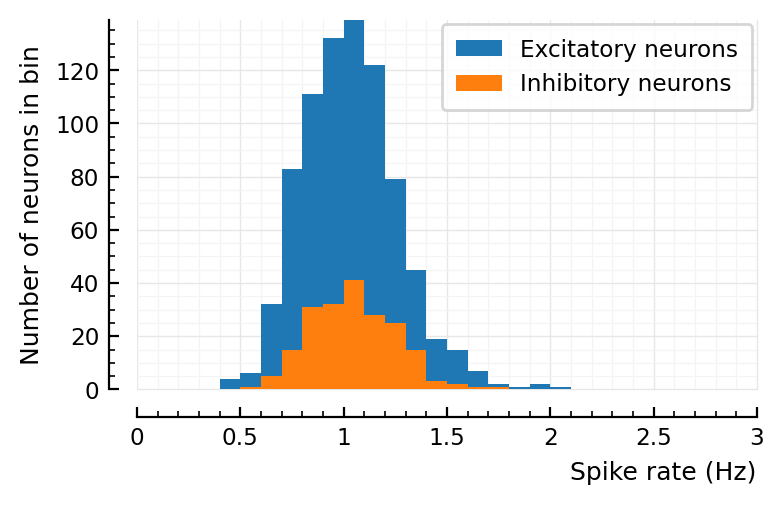

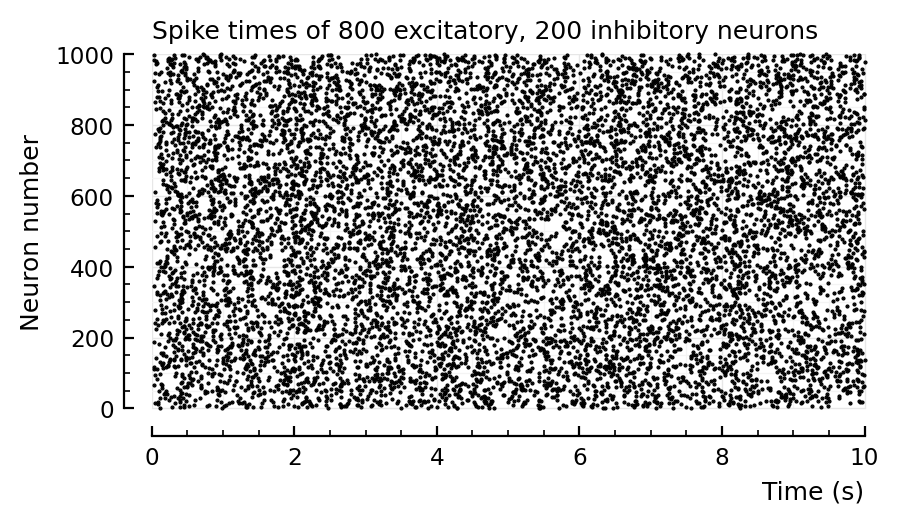

In [13]:
sim_and_plot(
    duration = 20seconds,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
);
# Default values

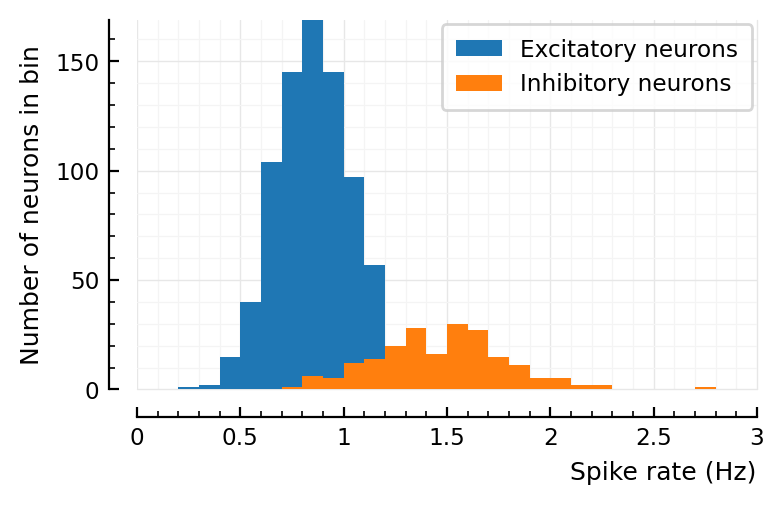

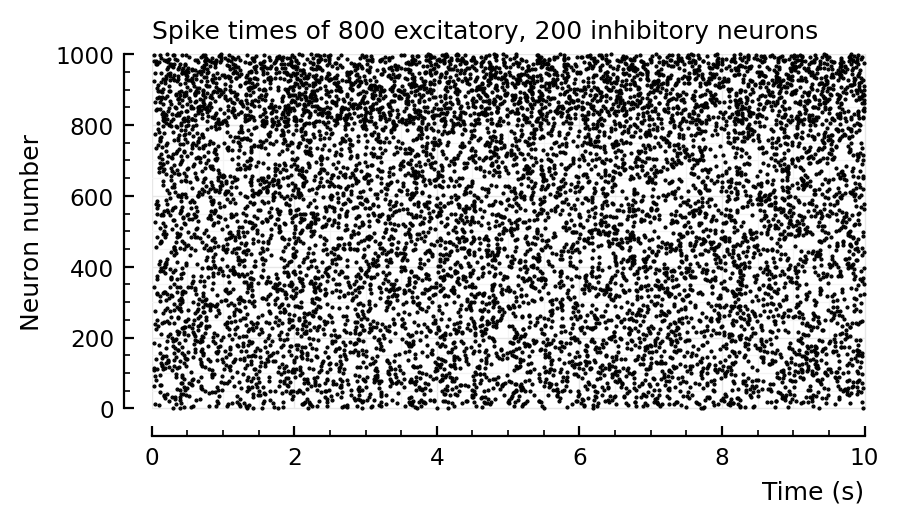

In [21]:
d = 2  # to lower firing rate
sim_and_plot(
    duration = 20seconds,
    g_EE = 1 / d,
    g_EI = 4 / d,
    g_IE = 1 / d,
    g_II = 4 / d,
);
# Previous, wrong values

Aggregated over E and I, you can indeed be fooled that the fr histogram is lognormal.

## Roxin2011

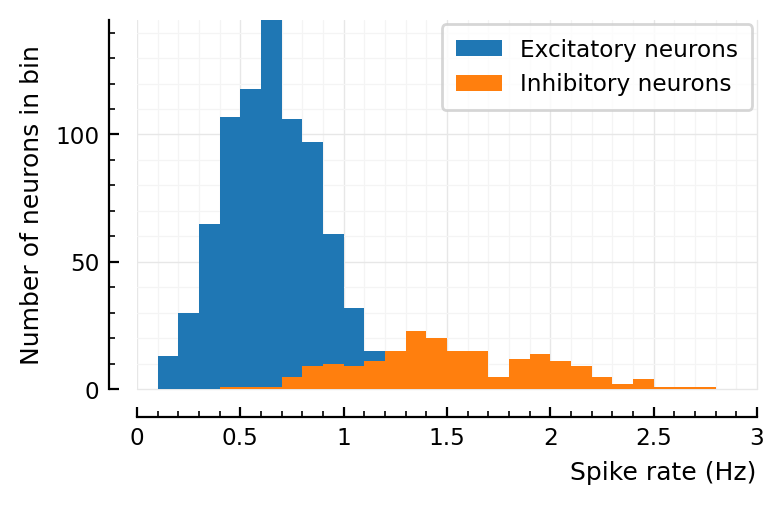

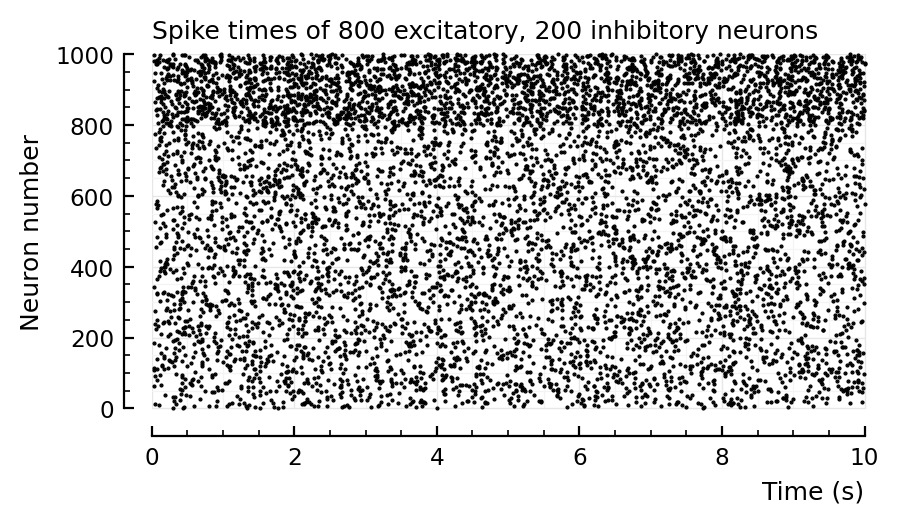

In [156]:
d = 6
p, s, spike_rates = sim_and_plot(
    duration = 10seconds,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
);
# Roxin2011 values

Recreating plots from roxin.  
Here: aggregate spike rates of inh and exc, on log scale

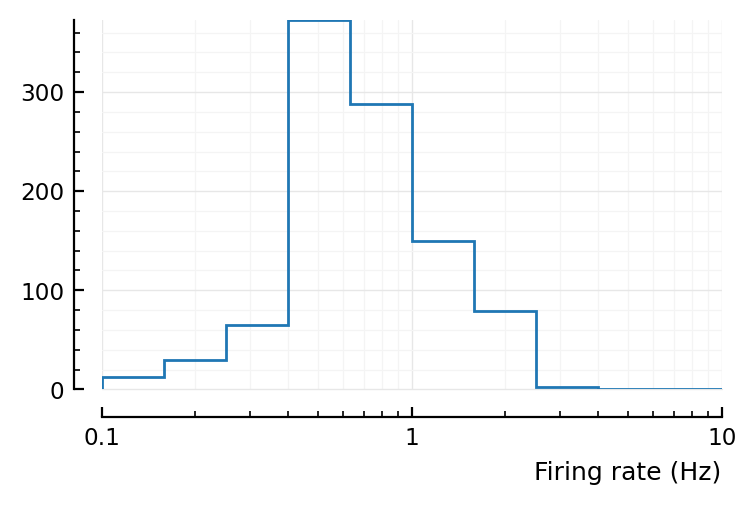

In [157]:
bins = exp10.(-1:0.2:1)
fig, ax = plt.subplots()
ax.hist(spike_rates; bins, histtype="step")
set(ax, xscale="log", xlabel="Firing rate (Hz)", xlim=(0.1,10));

Note that Roxin firing rates have much wider range: from 0.01 to 100

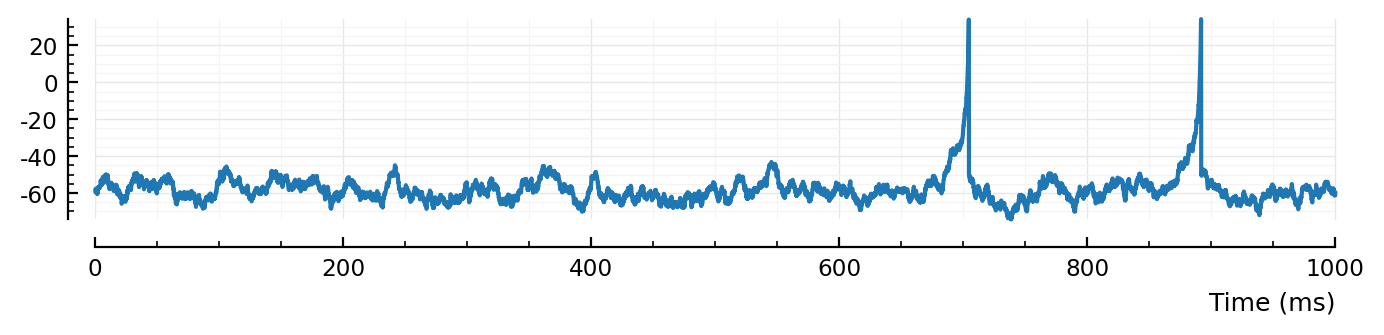

In [65]:
fig, ax = plt.subplots(figsize=(8,1.3))
plotsig(s.timesteps / ms, s.voltage_traces[1] / mV; ax, tlim=[0,1000], xlabel="Time (ms)");

## No lognormal weights

Roxin2011 finds that wider synaptic strength distribution gives __narrower__ firing rate distribution.
So let's do as they do in most plots, and give no variance at all to the synaptic weights.

Running simulation: 100%|███████████████████████████████| Time: 0:00:09
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\61e108c7773a503f.jld2` … done (0.2 s)


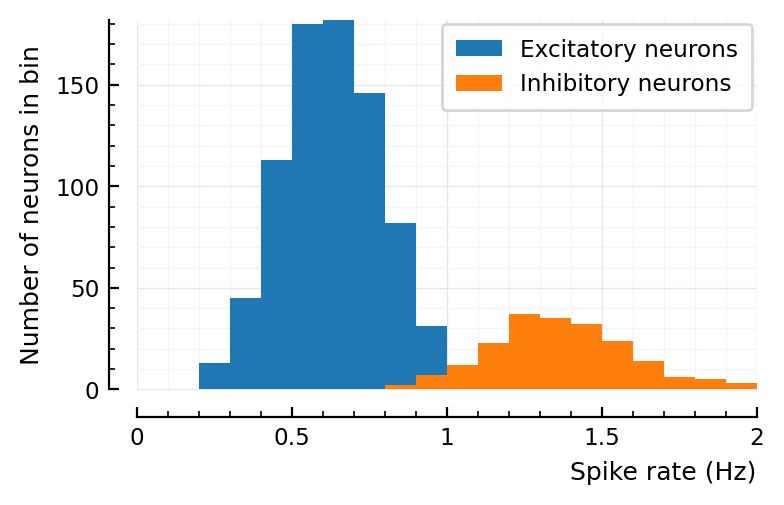

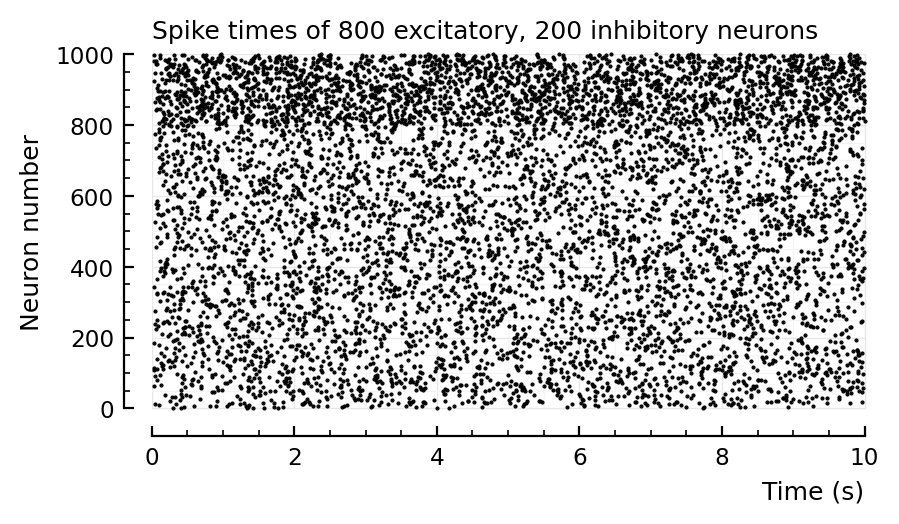

In [51]:
d = 6
p, s, spike_rates = sim_and_plot(
    duration = 20seconds,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    syn_strengths = LogNormal_with_mean(20nS, 0)  # ← zero variance
);
# Roxin2011 values

Result: nope. Not wider

## Positive-mean input current

Positive as in: excitatory. (Previous defaults had zero-mean input current. But Roxin had positive mean; dV/dt ~ +I_ext in their eq. In our eq, dV/dt ~ –I_ext).

Also, they have lower p_conn than our default of 10%. (Result after changing this: not much difference)

In [97]:
1/√.1ms

3162.277660168379

Running simulation: 100%|███████████████████████████████| Time: 0:00:01
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\2d8e1e3dedc55948.jld2` … done (0.1 s)


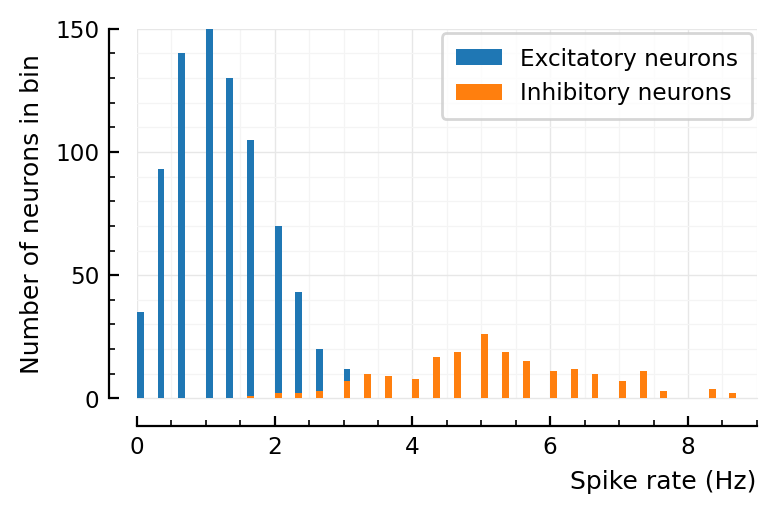

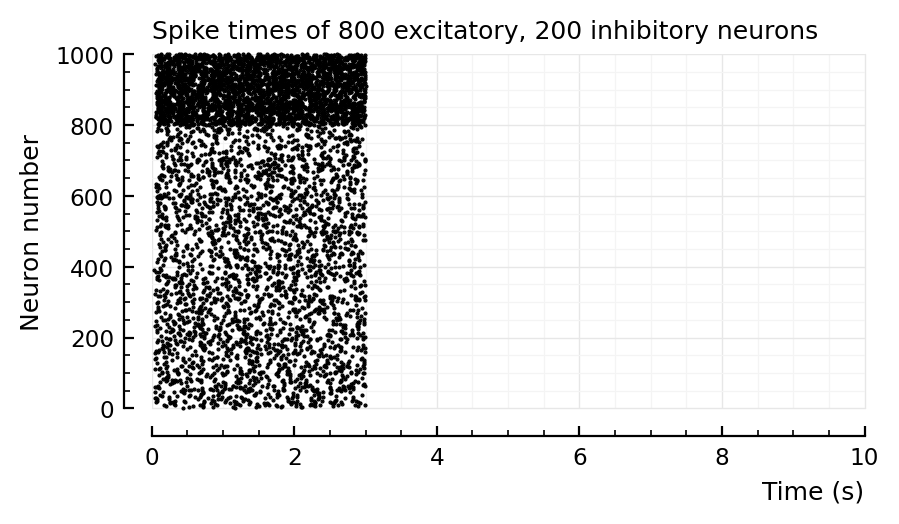

In [96]:
d = 6
p, s, spike_rates = sim_and_plot(
    duration = 3seconds,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.42 * pA/√seconds, 4 * pA/√seconds),
);
# Roxin2011 values

The longer you simulate, the narrower both distributions seem to become.  

So I could see obtaining the approximate results of Roxin2011 figure 8:
- simulate for a short time  (they did not report their simulation time. But given that they have 2000x the number of neurons as us here, it can't have been very long).
- give the inhibitory neurons less external current (which is indeed what they did): their distribution will then overlap more with the excitatory one
- plot the firing rates in aggregate (not separate as I did here).

## Shape of normal on log scale

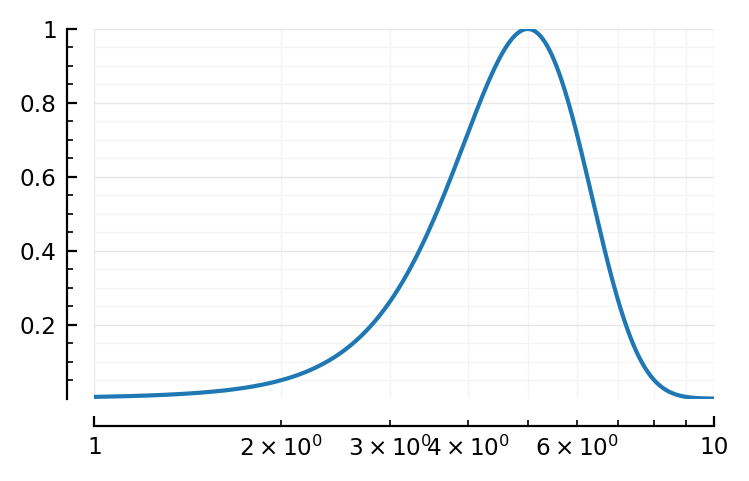

In [65]:
x = 1:0.01:10
y = @. exp(-(x-5)^2 / 3)
fig,ax = plt.subplots()
ax.plot(x,y);
set(ax, xscale="log");

Looks like the "very close to lognormal" plots in roxin.

## Truncated normal is 'heavy tailed'

Fig 5C of Roxin

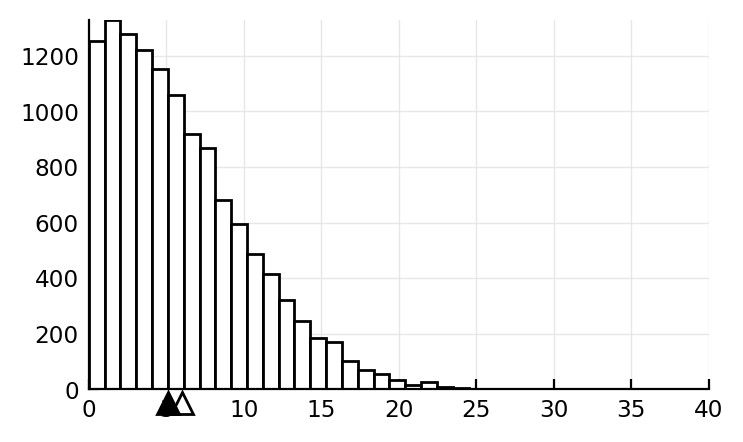

In [161]:
distr = TruncatedNormal(1Hz, 7Hz, 0Hz, Inf*Hz)  # mean, std, left bound, right bound
fr = rand(distr, 12500)
plt.hist(fr, bins=30, ec="k", fc="w")
plt.plot(mean(fr), -50, "w^", clip_on=false, mec="k", ms=8)
plt.plot(median(fr), -50, "k^", clip_on=false, mec="k", ms=8)
plt.ylim(bottom=0)
plt.xlim(0, 40);

In [162]:
median(fr), mean(fr)

(5.1193548485998175, 5.988978579872706)

tbf Roxin had a bit larger diff between these.

## Sum of two normals

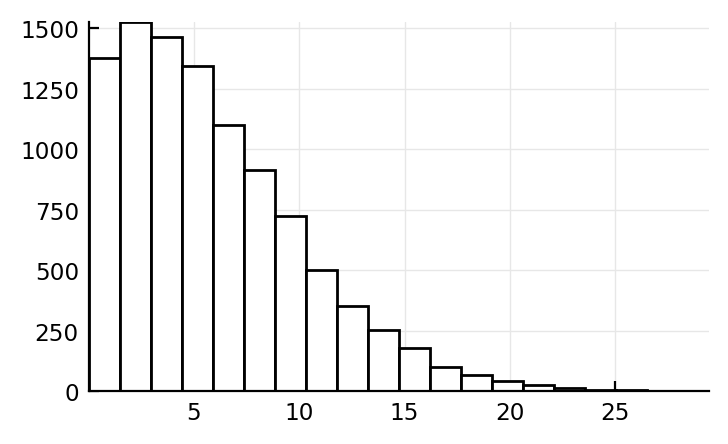

In [173]:
distr = truncated(MixtureModel(Normal, [(2Hz,5Hz), (8Hz,6Hz)], [0.8, 0.2]), lower=0Hz)
fr = rand(distr, 10_000)
plt.hist(fr, bins=20, ec="k", fc="w");

log scale:

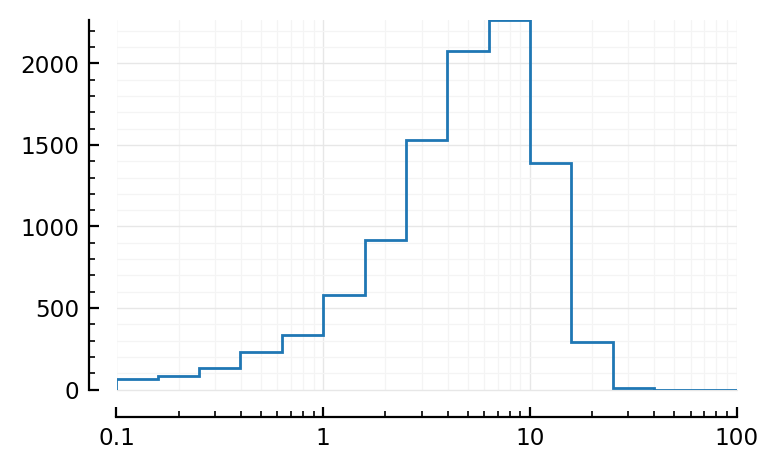

In [176]:
bins = exp10.(-1:0.2:3)
fig, ax = plt.subplots()
ax.hist(fr; bins, histtype="step")
set(ax, xscale="log", xlim=(0.1,100));

Looks very much like fig 8D.

## Sanity check

Running simulation: 100%|███████████████████████████████| Time: 0:00:01
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\4154eaf3081de0da.jld2` … done (0.8 s)


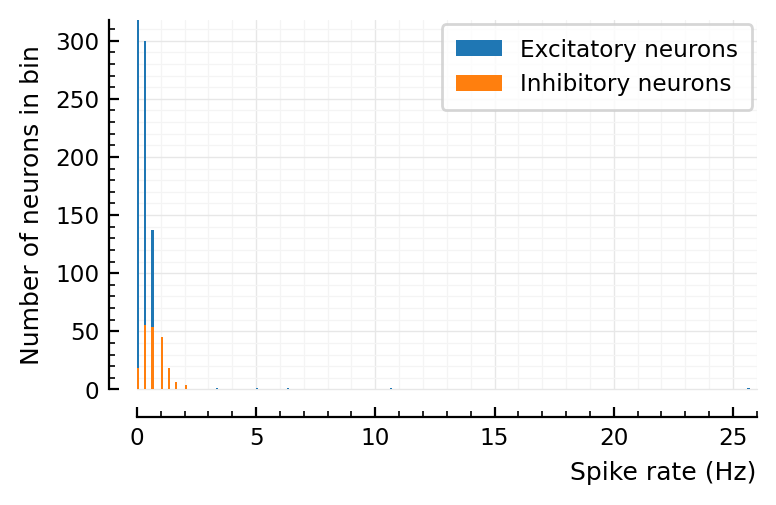

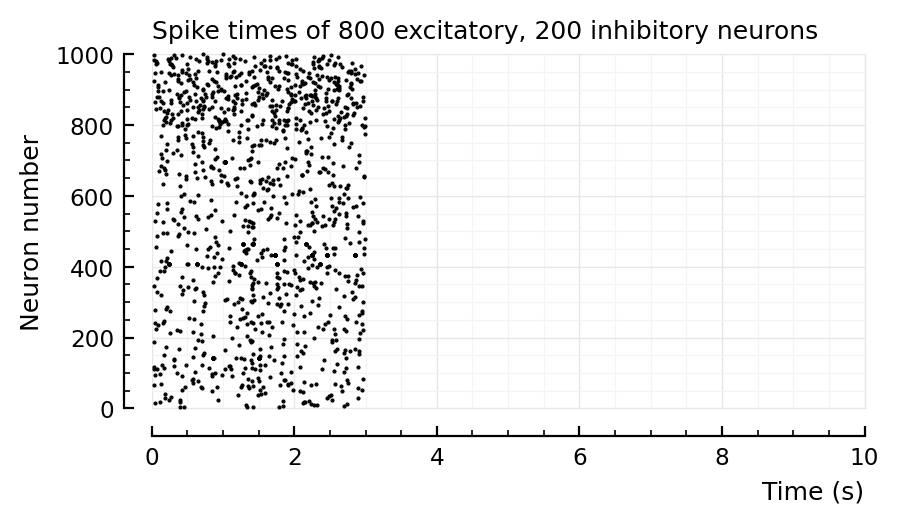

In [14]:
p, s, spike_rates = sim_and_plot(
    duration = 3seconds,
    g_EE = 0,
    g_EI = 0,
    g_IE = 600,
    g_II = 0,
    to_record = [696],
);

In [46]:
s.spike_times[812] / ms .+ 10

1-element Vector{Float64}:
 1021.599999999905

In [51]:
s.spike_times[696] / ms

10-element Vector{Float64}:
 1022.0999999999038
 1022.2999999999038
 1022.4999999999038
 1022.8999999999038
 1023.2999999999037
 1023.6999999999036
 1024.0999999999037
 1024.4999999999036
 1025.0999999999035
 1025.8999999999035

In [57]:
v,u,g_exc,g_inh = s.signals[696];

In [60]:
@unpack E_exc, E_inh = p.sim.general.synapses
I = @. (  g_exc * (v - E_exc)
        + g_inh * (v - E_inh));

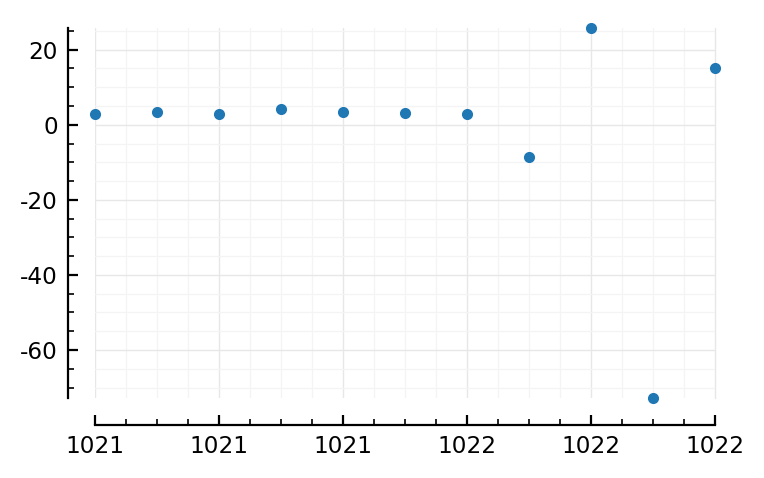

In [65]:
plotsig(s.timesteps / ms, (v .- E_inh) / mV, tlim=[1021,1022], marker=".", linestyle="None");

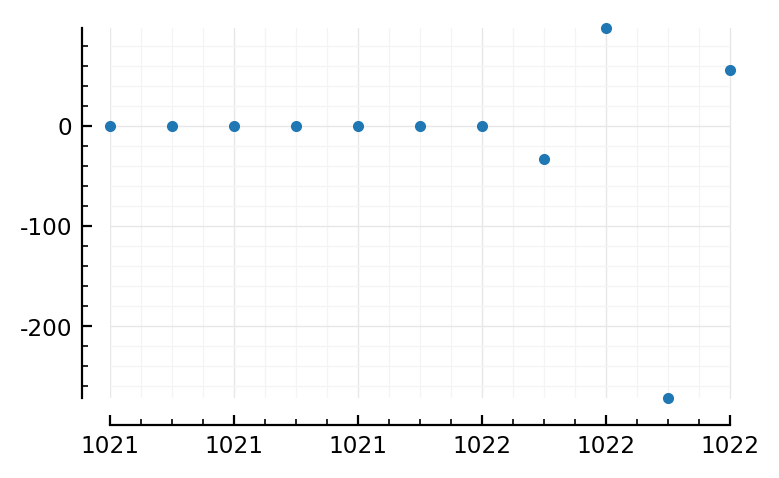

In [63]:
plotsig(s.timesteps / ms, I / nA, tlim=[1021,1022], marker=".", linestyle="None");

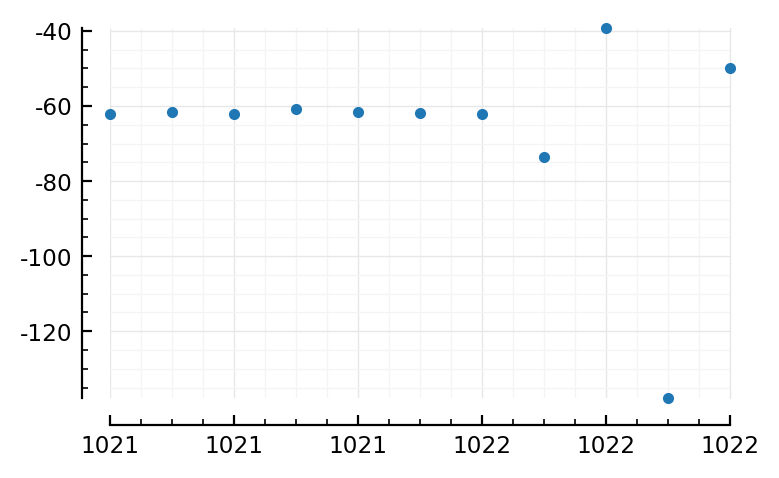

In [55]:
plotsig(s.timesteps / ms, s.signals[696].v / mV, tlim=[1021,1022], marker=".", linestyle="None");

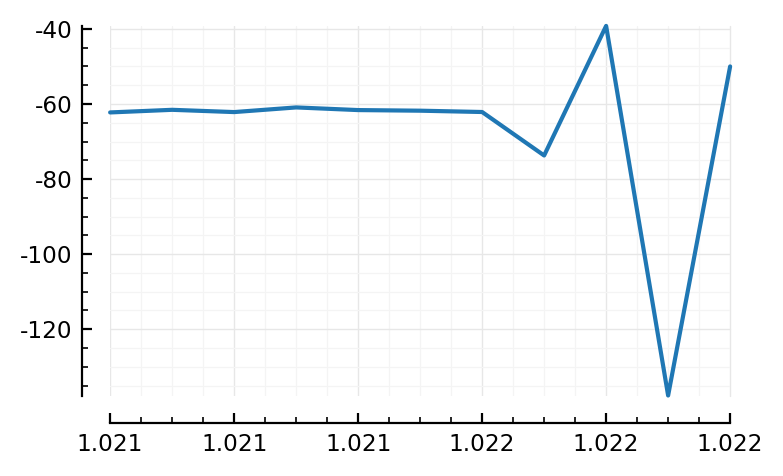

In [53]:
plotsig(s.timesteps, s.signals[696].v / mV, tlim=[1.021,1.022]);

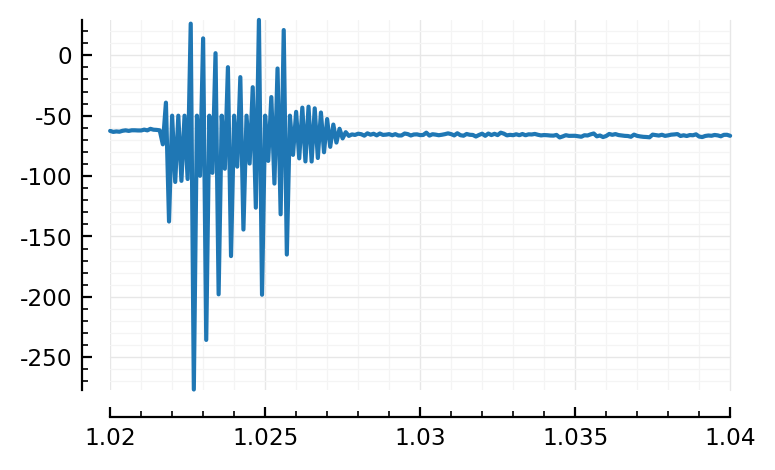

PyObject <AxesSubplot:>

In [52]:
plotsig(s.timesteps, s.signals[696].v / mV, tlim=[1.02,1.04])

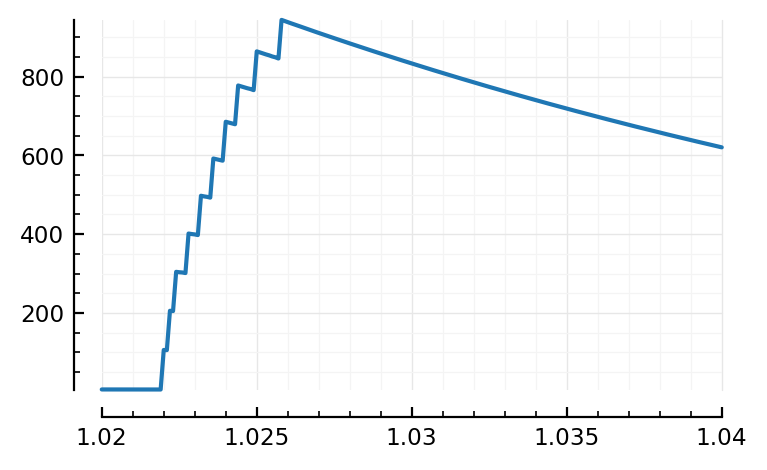

In [24]:
plotsig(s.timesteps, s.signals[696].u / pA, tlim=[1.02,1.04]);

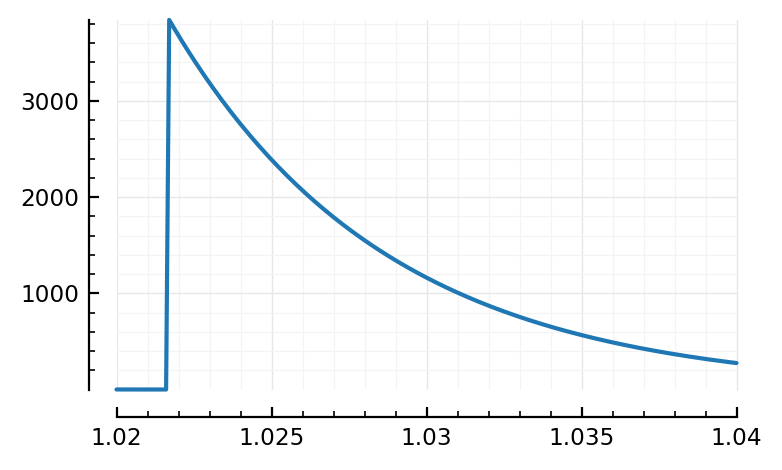

In [26]:
plotsig(s.timesteps, s.signals[696].g_inh / nS, tlim=[1.02,1.04]);

In [112]:
numspikes = length.(s.spike_times)

ComponentVector{Int64}(exc = [1, 3, 0, 0, 1, 0, 3, 1, 0, 1  …  1, 0, 0, 0, 1, 1, 2, 1, 0, 2], inh = [1, 1, 2, 2, 1, 3, 2, 3, 2, 1  …  1, 1, 2, 1, 0, 0, 4, 2, 3, 1])

In [113]:
findmax(numspikes)  # (val, index)

(58, 696)

In [84]:
s.spike_times[696] / ms

58-element Vector{Float64}:
  283.09999999998513
  283.2999999999851
  283.6999999999851
  284.099999999985
  284.499999999985
  284.8999999999849
  285.2999999999849
  285.69999999998487
  286.2999999999848
  951.6999999999115
  951.8999999999114
  952.0999999999115
  952.4999999999114
    ⋮
 1876.0999999998098
 1876.6999999998097
 2310.800000000452
 2311.0000000004525
 2311.4000000004535
 2311.800000000454
 2312.200000000455
 2312.600000000456
 2313.0000000004566
 2313.4000000004576
 2314.000000000459
 2315.0000000004607

Clusters, these always start a bit more than 10 ms (tx delay) after the input spikes of 812.
(found by printing spiketimes of all 696's inputs)

In [86]:
s.spike_times[812] / ms

6-element Vector{Float64}:
  272.39999999998633
  941.1999999999126
 1694.1999999998297
 1784.5999999998198
 1862.9999999998113
 2300.40000000043

In [88]:
labels(s.neuron_IDs)[812]

"inh[12]"

I wanna know if syn between these two is particularly strong.

In [91]:
[syn for syn in s.output_synapses[812] if s.postsyn_neuron[syn] == 696]

1-element Vector{Int64}:
 69244

In [103]:
s.syn_strengths[69244] / nS

3894.2034540205022

In [97]:
sort(s.syn_strengths[s.syns.inh_to_exc] / nS)

15923-element Vector{Float64}:
    1.9766044536578071
    2.188271086170034
    2.2988694124487004
    2.386741975213665
    2.5107083436583952
    2.5866747022907055
    2.6547608771121114
    2.749536896693771
    2.7665108323914187
    2.9194501336756873
    2.974603768194044
    3.1030473064492887
    3.1350052682906
    ⋮
 1968.049722427362
 1984.9063895892796
 1999.3965878497127
 2072.4237489509205
 2182.278608908274
 2273.2785123338335
 2467.500389769674
 3173.2421412651684
 3240.673205030154
 3894.2034540205022
 3899.103610867894
 5048.3299605142765

So our man has the second highest synaptic strength.

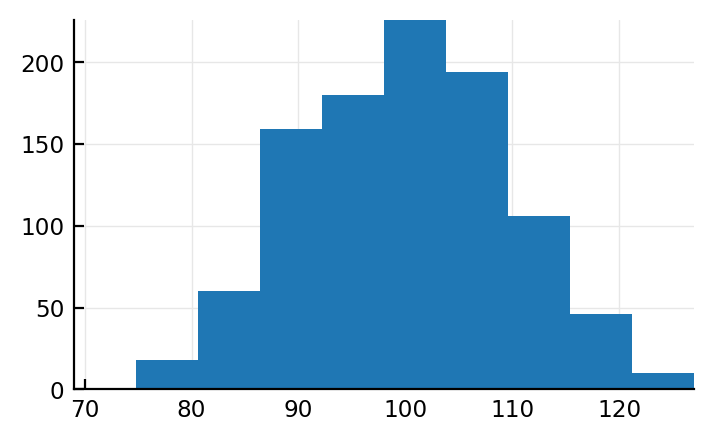

In [44]:
plt.hist(length.(values(s.input_neurons)));